In [14]:
import os, sys
import math

import torch

from matplotlib import pyplot as plt
import seaborn as sns
#############

SRC_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "protdiff"
)
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import datasets

BIN_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "bin"
)
assert os.path.isdir(BIN_DIR)
sys.path.append(BIN_DIR)
from sample import sample

Load in dataset of proteins and get the natural distribution of angles

In [2]:
cath_dset = datasets.CathConsecutiveAnglesDataset(split='train')
len(cath_dset)

12673

In [3]:
select_by_attn = lambda x: x['angles'][torch.where(x['attn_mask'])]

cath_dset_values = torch.vstack([select_by_attn(cath_dset[i]) for i in range(len(cath_dset))])
cath_dset_values.shape

torch.Size([2527164, 4])

Generate some proteins

In [4]:
sampled_proteins = sample(
    100,
    "/home/t-kevinwu/projects/protein_diffusion/models/1000_timesteps_linear_variance_schedule_64_batch_size_0.0001_lr_0.5_gradient_clip/lightning_logs/version_0/checkpoints/epoch=9-step=1990.ckpt",
    "/home/t-kevinwu/projects/protein_diffusion/models/1000_timesteps_linear_variance_schedule_64_batch_size_0.0001_lr_0.5_gradient_clip/training_args.json",
)
sampled_proteins.shape

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100, 512, 4])

In [9]:
sampled_proteins_flat = sampled_proteins.flatten(start_dim=0, end_dim=1)
sampled_proteins_flat.shape

torch.Size([51200, 4])

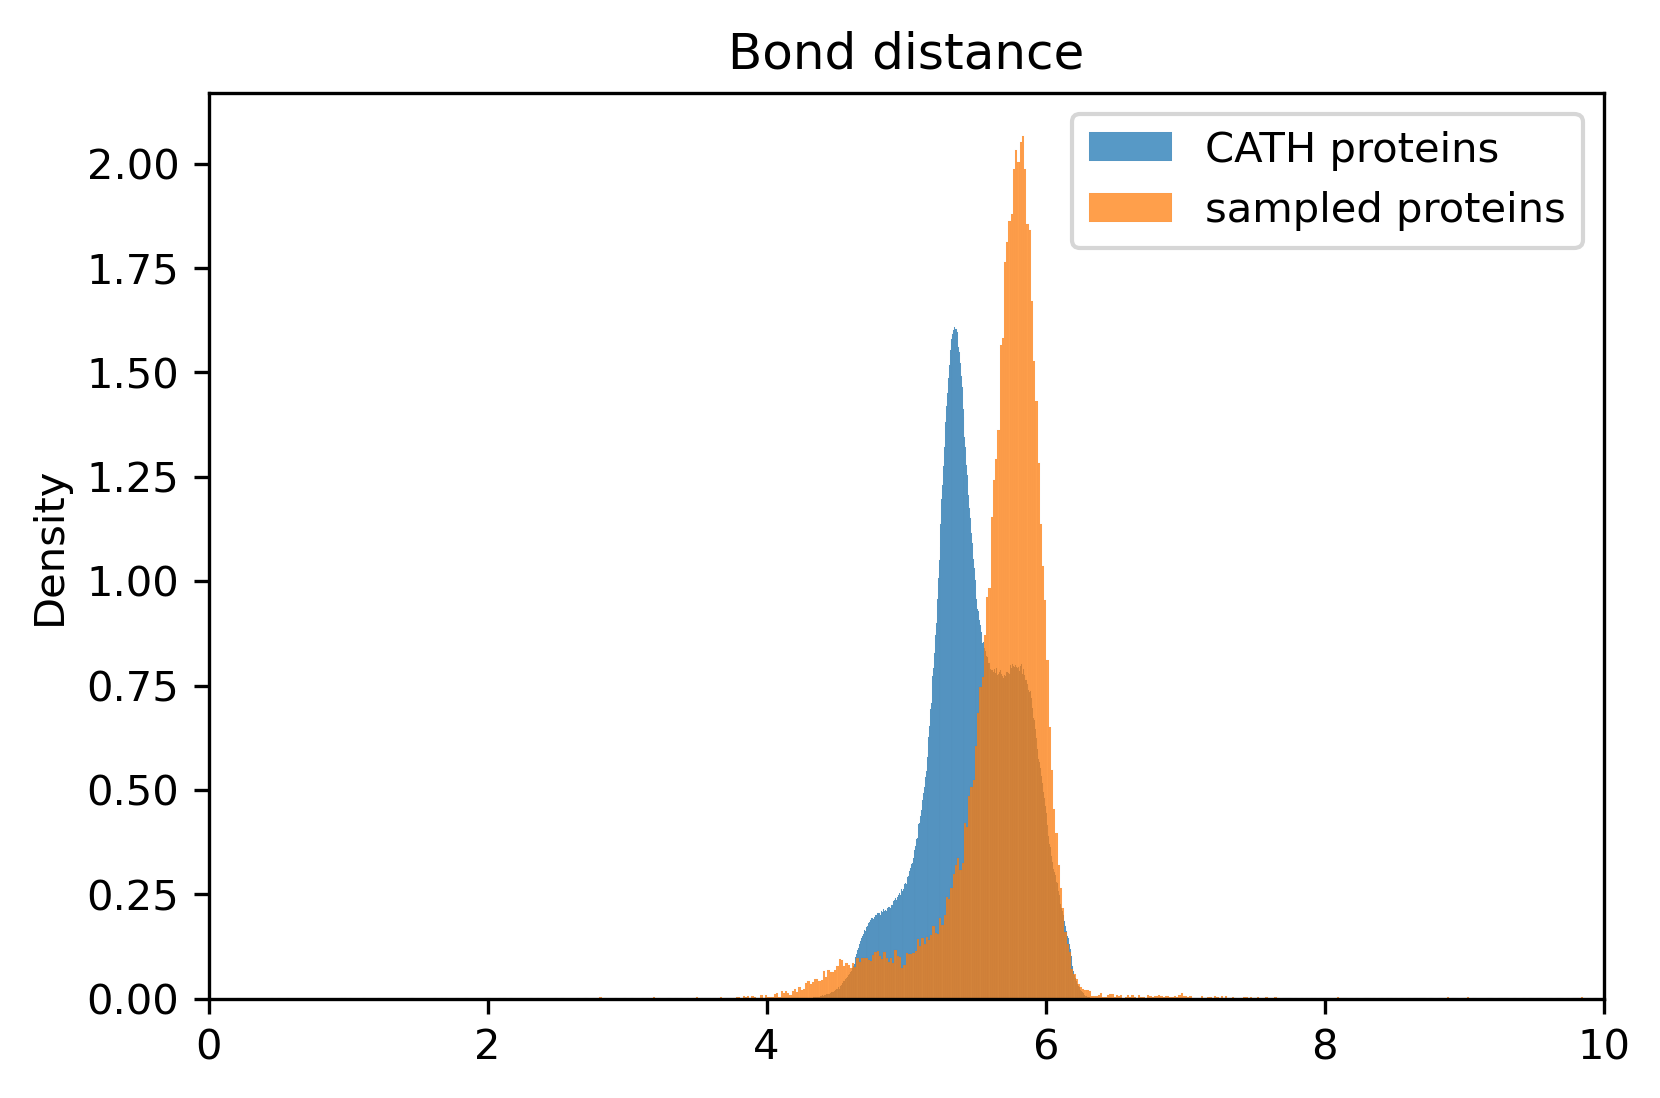

In [21]:
fig, ax = plt.subplots(dpi=300)
sns.histplot(cath_dset_values[:, 0], stat='density', label="CATH proteins", ax=ax, color='tab:blue')
sns.histplot(sampled_proteins_flat[:, 0], stat='density', label='sampled proteins', ax=ax, color='tab:orange')
ax.legend()
ax.set(
    xlim=(0, 10),
    title="Bond distance",
)
fig.show()

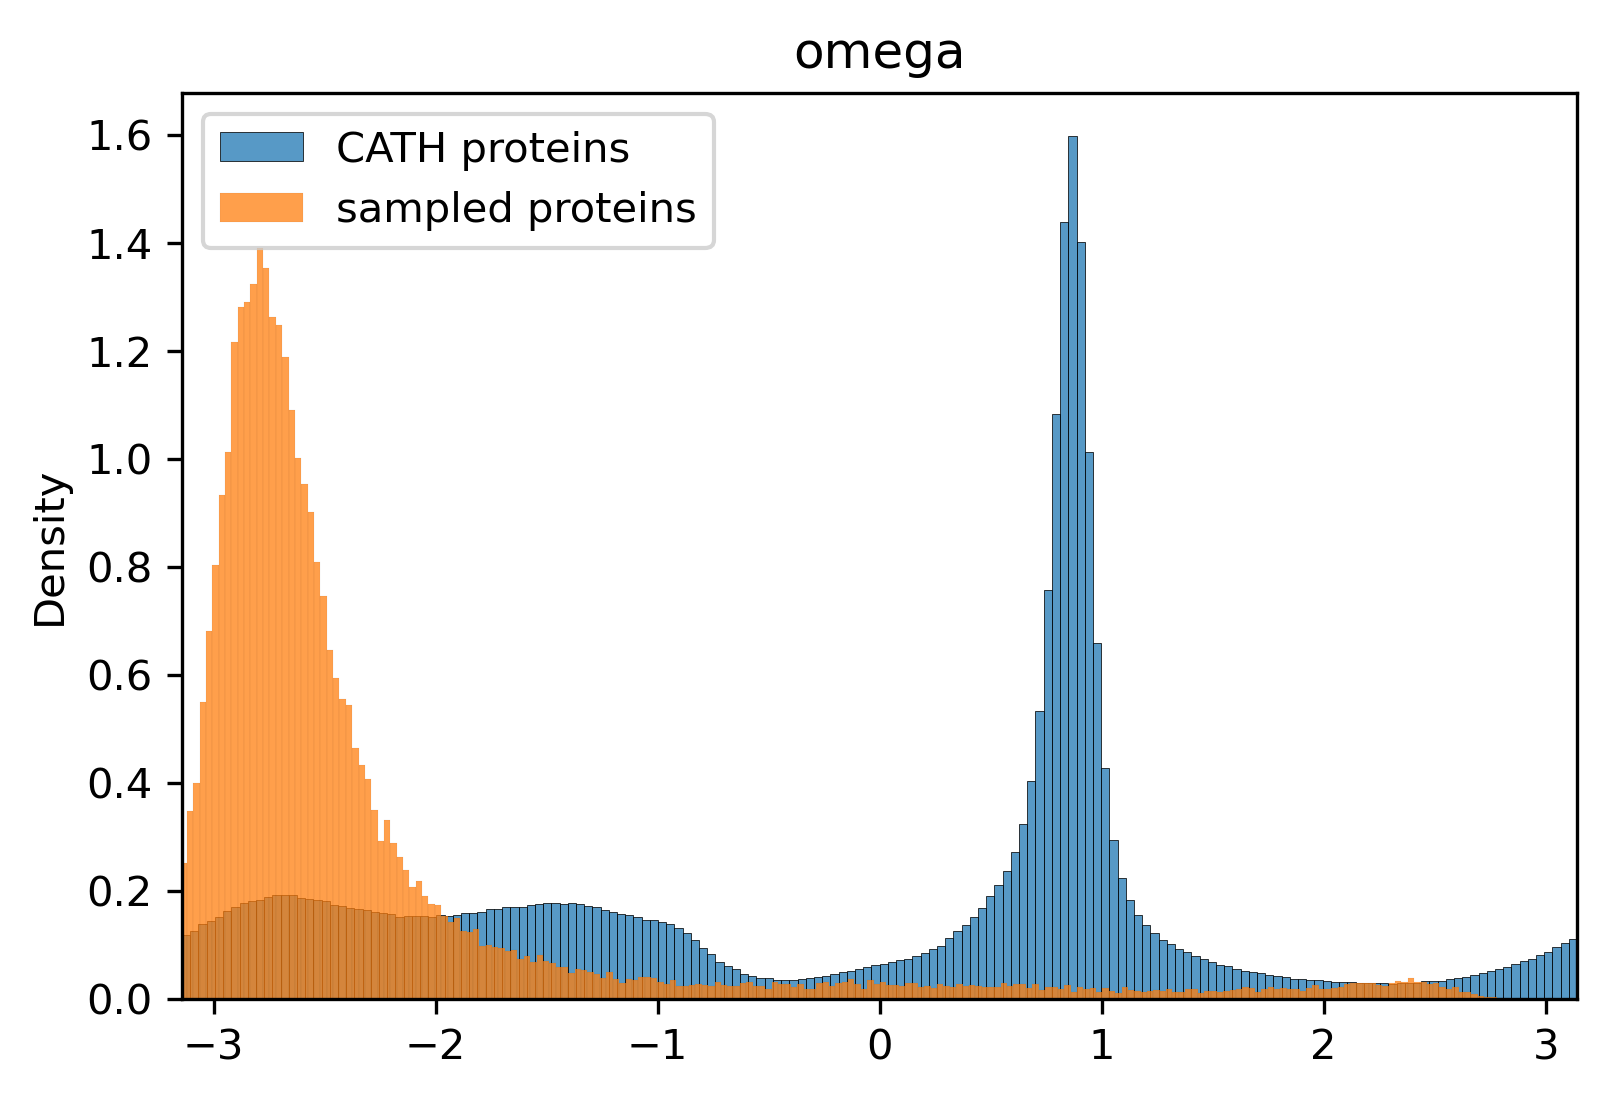

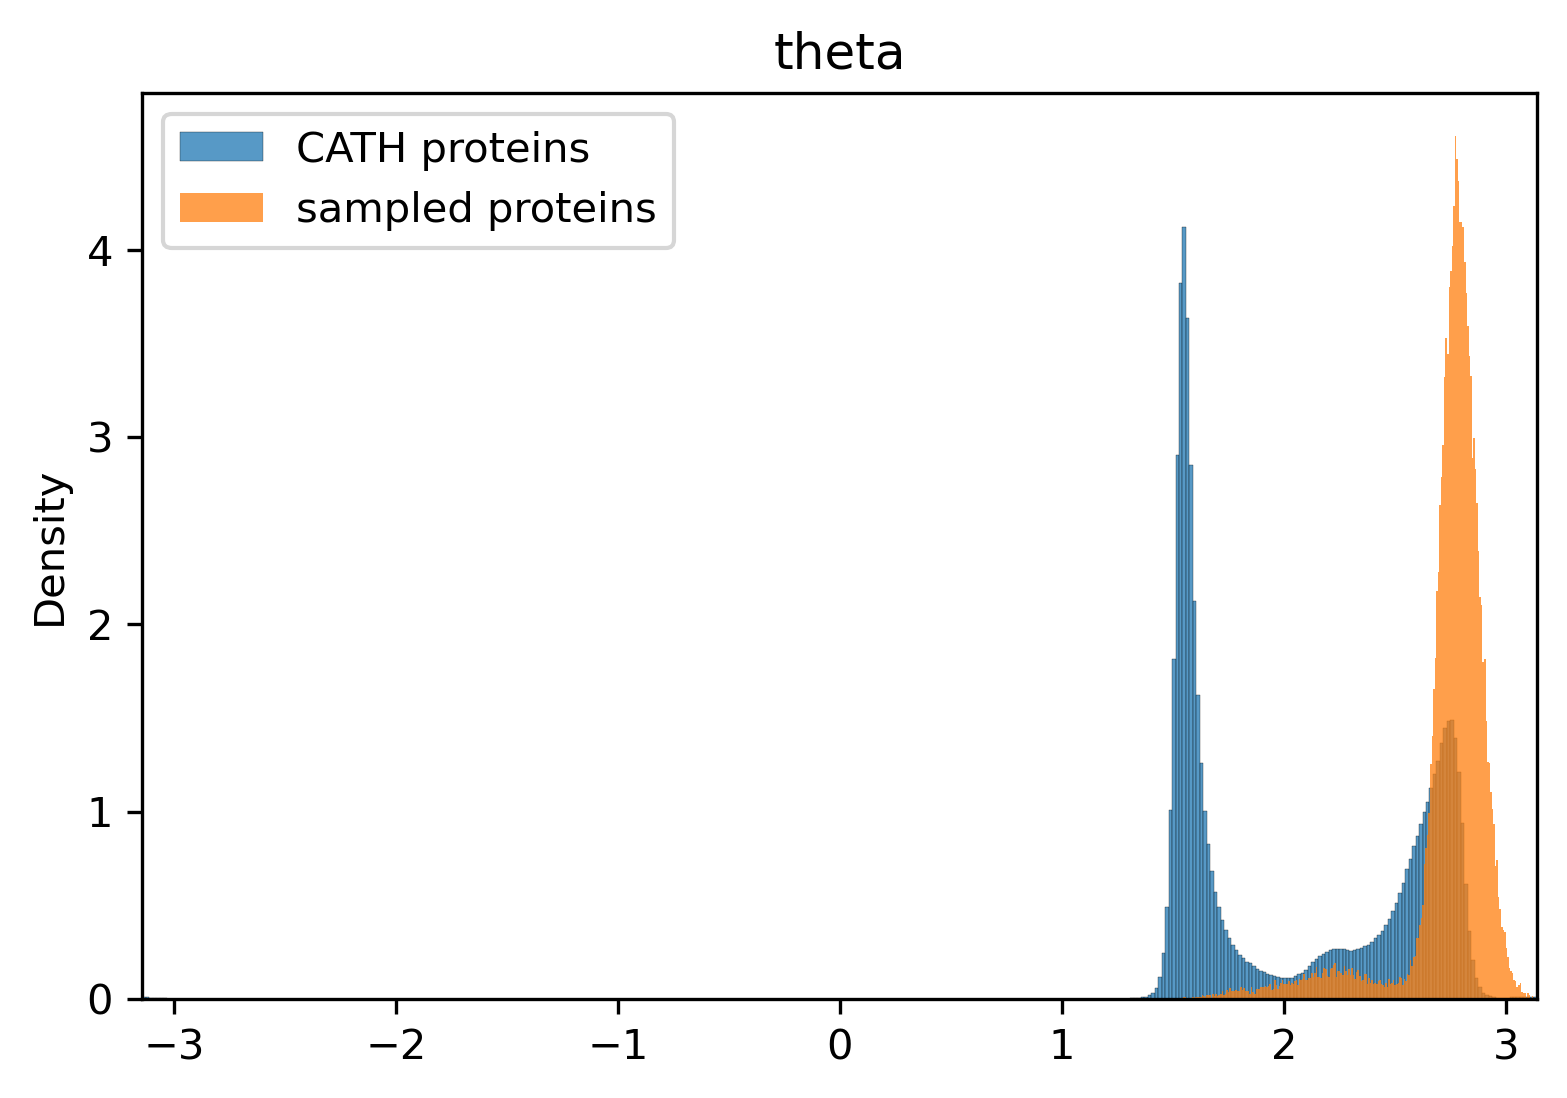

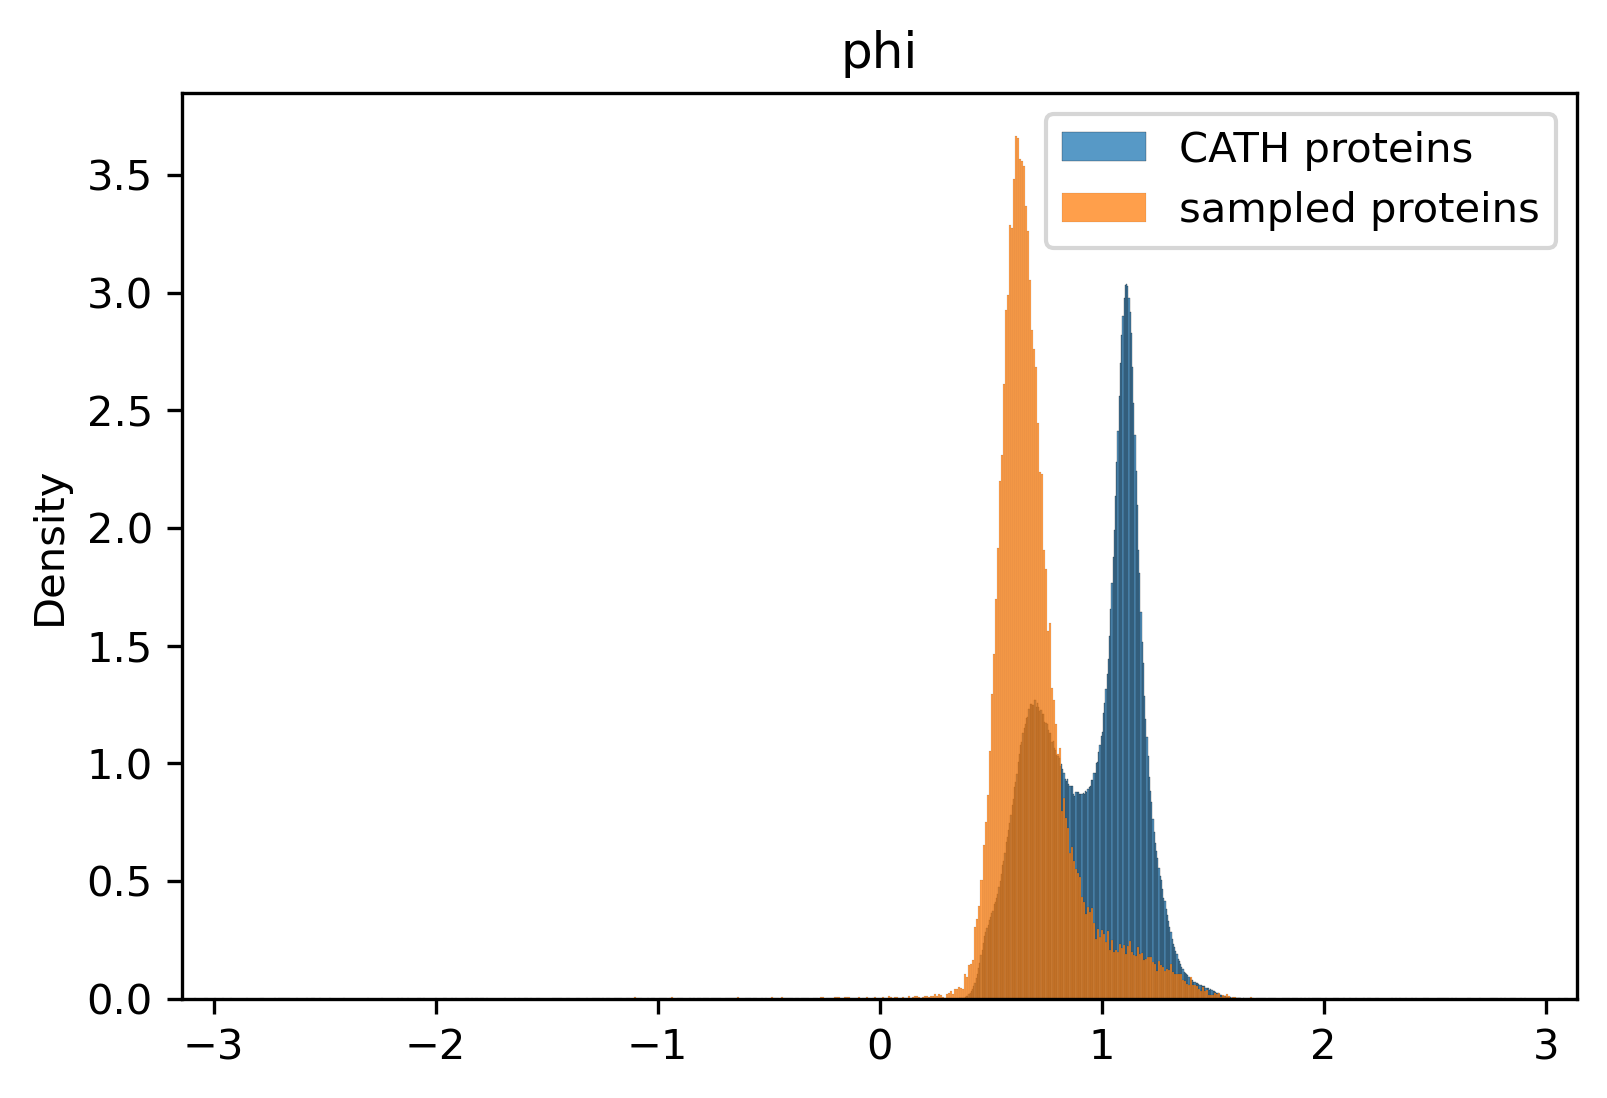

In [20]:
for i in range(1, 4):
    fig, ax = plt.subplots(dpi=300)
    sns.histplot(cath_dset_values[:, i], stat='density', label="CATH proteins", ax=ax, color='tab:blue')
    sns.histplot(sampled_proteins_flat[:, i], stat='density', label='sampled proteins', ax=ax, color='tab:orange')
    ax.legend()
    ax.set(
        xlim=(-math.pi, math.pi),
        title=['omega', 'theta', 'phi'][i-1],
    )
    fig.show()